In [1]:
!pip install keras_cv
!pip install tensorflow
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [3]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
import requests
import zipfile

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


# Getting Data

## Dataset and Training Parameters

In [30]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCH = 20
GLOBAL_CLIPNORM = 10.0

## Dataset Preparation

In [5]:
class_ids = ["Waldo"]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "/content/drive/MyDrive/waldo_data/data/images"
path_annot = "/content/drive/MyDrive/waldo_data/data/Annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [13]:
# xml_files

**Next is parsing the XML annotation files to store the labels and bounding box annotations needed for training.**

In [8]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/47 [00:00<?, ?it/s]

[[500.0, 1313.0, 526.0, 1361.0]]

In [31]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

TypeError: pylist may not be a RaggedTensor or RaggedTensorValue.

In [32]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [33]:
val_data.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64),
 RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64))

In [34]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1.0, 1.0),
            bounding_box_format="xyxy",
        ),
        keras_cv.layers.RandomRotation(factor=0.15, bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1.0, 1.0),
            bounding_box_format="xyxy",
        ),
        keras_cv.layers.RandomHue((0.5, 0.5), [0, 255]),
        keras_cv.layers.RandomContrast([0, 255], (0.5, 0.5)),
        keras_cv.layers.RandomSaturation((0.5, 0.5)),
    ]
)

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [35]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [36]:
val_ds.element_spec

{'images': TensorSpec(shape=(8, 640, 640, 3), dtype=tf.float32, name=None),
 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([8, None]), tf.float32, 1, tf.int64),
  'boxes': RaggedTensorSpec(TensorShape([8, None, None]), tf.float32, 1, tf.int64)}}

In [37]:
# Check the first few elements in val_ds
# for element in val_ds.take(5):
#     print(element)

In [38]:
# # Check the first few elements in train_ds
# for element in train_ds.take(1):
#     print(element)

In [39]:
train_ds

<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(8, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([8, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([8, None, None]), tf.float32, 1, tf.int64)}}>

In [40]:
val_ds.element_spec

{'images': TensorSpec(shape=(8, 640, 640, 3), dtype=tf.float32, name=None),
 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([8, None]), tf.float32, 1, tf.int64),
  'boxes': RaggedTensorSpec(TensorShape([8, None, None]), tf.float32, 1, tf.int64)}}

In [41]:
# Check the number of elements in the datasets
print("Number of elements in train_ds:", len(list(train_ds)))
print("Number of elements in val_ds:", len(list(val_ds)))

Number of elements in train_ds: 4
Number of elements in val_ds: 1


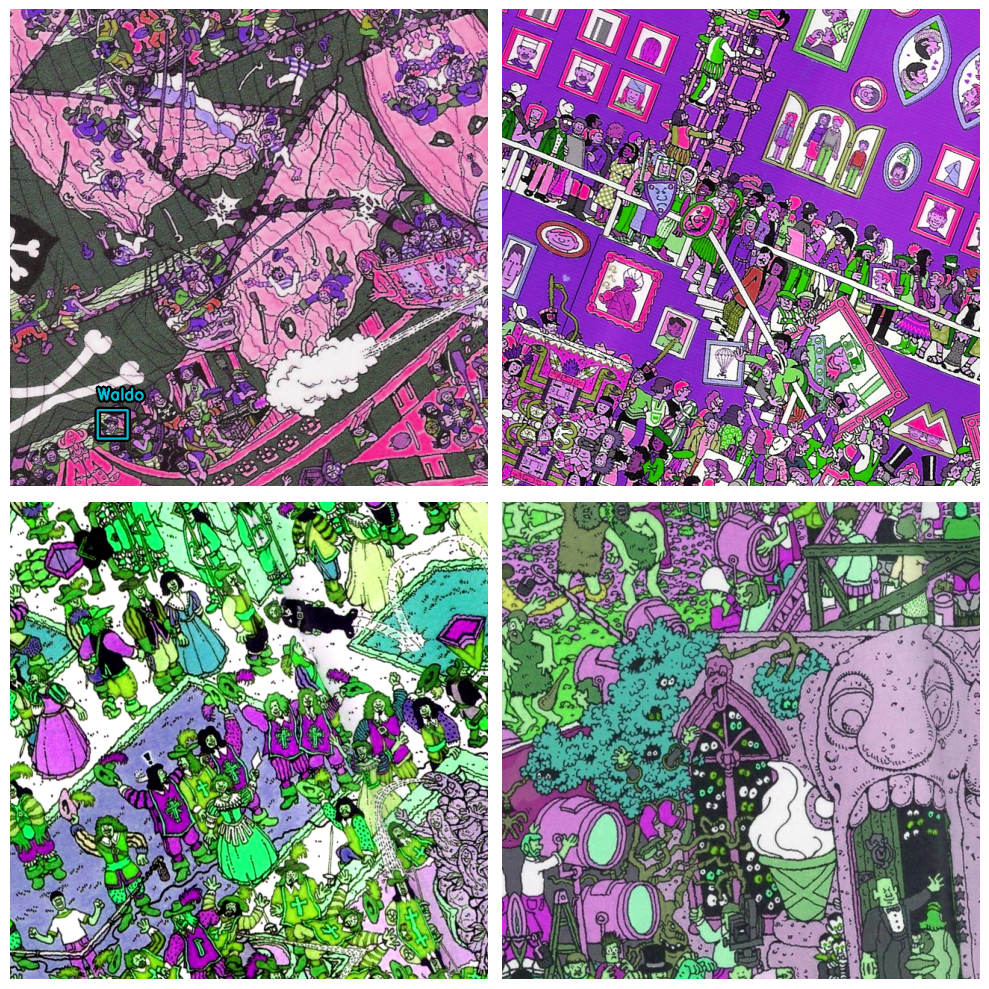

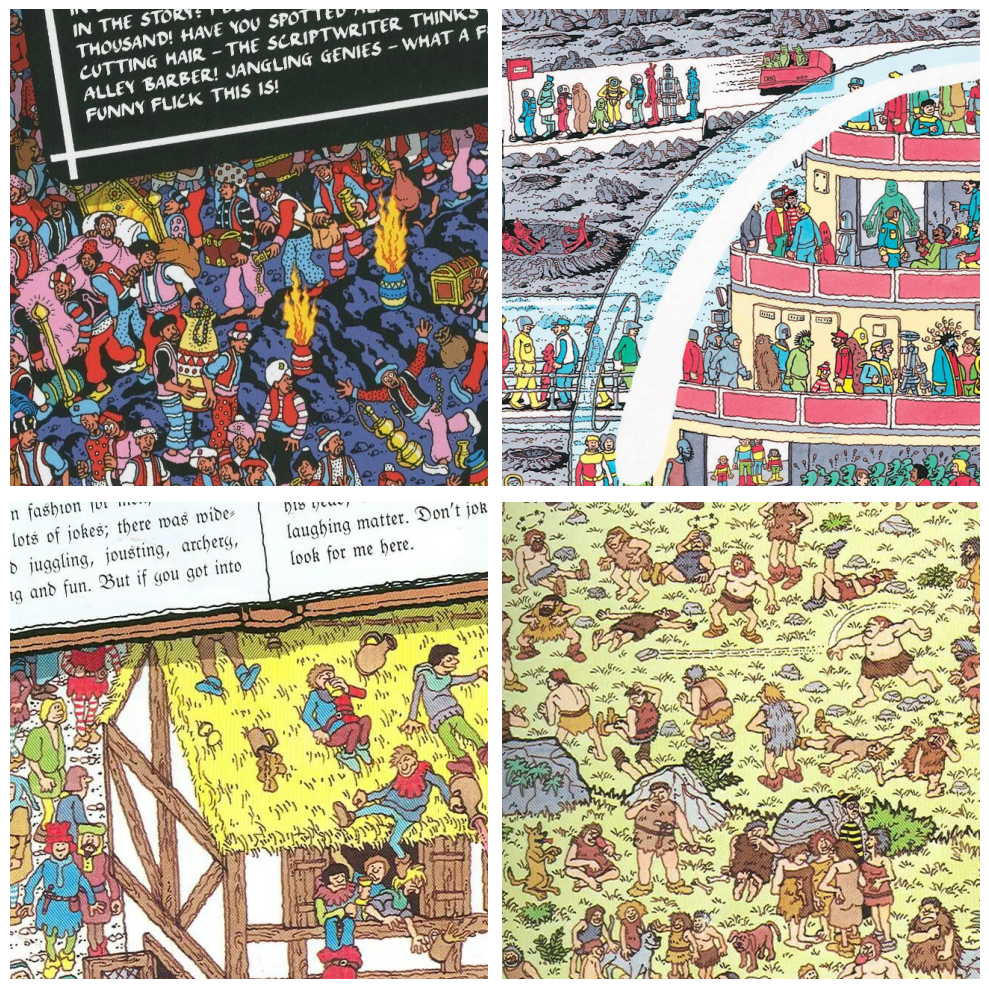

In [42]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    # inputs = inputs.take(1)
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [43]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [44]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",
    load_weights=True
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)

yolo.count_params()

100%|██████████| 647/647 [00:00<00:00, 701kB/s]
100%|██████████| 76.1M/76.1M [00:02<00:00, 33.4MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


41051523

In [45]:
for layer in yolo.layers:
  if isinstance(layer, tf.keras.layers.Conv2D):
    layer.trainable = False
  else:
    layer.trainable = True

In [46]:
# yolo.summary()

In [52]:
def focal_loss(y_true, y_pred):
  gamma = 2.0
  alpha = 0.25

  pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
  loss = -alpha * (1.0 - pt)**gamma * tf.math.log(tf.clip_by_value(pt, 1e-15, 1.0 - 1e-15))

  return loss

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss=focal_loss, box_loss="ciou"
)

In [53]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path + '.keras')  # Save the model when mAP improves

        return logs

In [54]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=75,
    restore_best_weights=True,
    monitor='val_loss',
    mode='max'
)

callbacks=[
    EvaluateCOCOMetricsCallback(val_ds, "model_yolov8large.h5"),
    tensorboard_callback,
    early_stopping
]

In [ ]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=callbacks
)

Epoch 1/20
2/4 [==============>...............] - ETA: 2:53 - loss: 5.7353 - box_loss: 5.7086 - class_loss: 0.0268

In [ ]:
history.history

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    for i in range(10):
        images, y_true = next(iter(dataset.take(i+1)))
        y_pred = model.predict(images)
        y_pred = bounding_box.to_ragged(y_pred)
        visualization.plot_bounding_box_gallery(
            images,
            value_range=(0, 255),
            bounding_box_format=bounding_box_format,
            # y_true=y_true,
            y_pred=y_pred,
            scale=4,
            rows=2,
            cols=2,
            show=True,
            font_scale=0.7,
            class_mapping=class_mapping,
        )
visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")